In [49]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate
from tensorflow.keras.optimizers import RMSprop, Adam

In [50]:
folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [52]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X_clinsig = []
y_clinsig = []

X_indolent = []
y_indolent = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray)) 
        if adc_t2 == 't2':
            if label == 'TRUE':
                X_clinsig.append(array)
                y_clinsig.append(1)
            else:
                X_indolent.append(array)
                y_indolent.append(0)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(len(y_indolent), len(y_clinsig)))

Original: indolent=200, clinsig=56


In [53]:
# Generate imgaes of minority class (clinsig)
X = []
y = []
X.extend(X_indolent)
X.extend(X_clinsig)
y.extend(y_indolent)
y.extend(y_clinsig)

datagen = ImageDataGenerator(
#                     rescale=1./255,
                    shear_range=0.05,
#                     zoom_range=[,1],
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
    
X_clinsig = np.array(X_clinsig)
y_clinsig = np.array(y_clinsig)
np.asarray(y_clinsig).astype('float32').reshape((-1,1))

for img in X_clinsig:
    img = img.reshape((1,) + img.shape)
    for x, val in zip(datagen.flow(img, batch_size=1), range(2)):
        im = x[0]
        X.append(im)
        y.append(1)

X = np.array(X)
y = np.array(y)
print(Counter(y))
print(len(X), len(y))

Counter({0: 200, 1: 168})
368 368


In [54]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=276, nval=92


In [55]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [56]:
chanDim = 3

model = Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [57]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-5), metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=3e-4), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [58]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [59]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 2s 540ms/step - loss: 0.7051 - acc: 0.5377 - val_loss: 0.6930 - val_acc: 0.5625
Epoch 2/170
4/4 [==============================] - 1s 175ms/step - loss: 0.7211 - acc: 0.5189 - val_loss: 0.6931 - val_acc: 0.5156
Epoch 3/170
4/4 [==============================] - 1s 224ms/step - loss: 0.7056 - acc: 0.5236 - val_loss: 0.6932 - val_acc: 0.4844
Epoch 4/170
4/4 [==============================] - 1s 326ms/step - loss: 0.6964 - acc: 0.5508 - val_loss: 0.6927 - val_acc: 0.5625
Epoch 5/170
4/4 [==============================] - 1s 290ms/step - loss: 0.7022 - acc: 0.5195 - val_loss: 0.6929 - val_acc: 0.5312
Epoch 6/170
4/4 [==============================] - 1s 275ms/step - loss: 0.7014 - acc: 0.5283 - val_loss: 0.6927 - val_acc: 0.5469
Epoch 7/170
4/4 [==============================] - 1s 293ms/step - loss: 0.6956 - acc: 0.5519 - val_loss: 0.6928 - val_acc: 0.5312
Epoch 8/170
4/4 [==============================] - 1s 268ms/step - loss: 0.6854 - a

4/4 [==============================] - 1s 173ms/step - loss: 0.6884 - acc: 0.5283 - val_loss: 0.6912 - val_acc: 0.5312
Epoch 64/170
4/4 [==============================] - 1s 182ms/step - loss: 0.7023 - acc: 0.5377 - val_loss: 0.6934 - val_acc: 0.5156
Epoch 65/170
4/4 [==============================] - 1s 184ms/step - loss: 0.6860 - acc: 0.5755 - val_loss: 0.6868 - val_acc: 0.5625
Epoch 66/170
4/4 [==============================] - 1s 185ms/step - loss: 0.6979 - acc: 0.5142 - val_loss: 0.6912 - val_acc: 0.5312
Epoch 67/170
4/4 [==============================] - 1s 199ms/step - loss: 0.7092 - acc: 0.5142 - val_loss: 0.6866 - val_acc: 0.5625
Epoch 68/170
4/4 [==============================] - 1s 191ms/step - loss: 0.6842 - acc: 0.5425 - val_loss: 0.6843 - val_acc: 0.5781
Epoch 69/170
4/4 [==============================] - 1s 222ms/step - loss: 0.6941 - acc: 0.5391 - val_loss: 0.6748 - val_acc: 0.6406
Epoch 70/170
4/4 [==============================] - 1s 177ms/step - loss: 0.6817 - acc: 0

Epoch 125/170
4/4 [==============================] - 1s 159ms/step - loss: 0.6754 - acc: 0.5802 - val_loss: 0.6988 - val_acc: 0.5000
Epoch 126/170
4/4 [==============================] - 1s 160ms/step - loss: 0.6950 - acc: 0.5236 - val_loss: 0.6926 - val_acc: 0.5625
Epoch 127/170
4/4 [==============================] - 1s 155ms/step - loss: 0.6823 - acc: 0.5943 - val_loss: 0.6949 - val_acc: 0.5469
Epoch 128/170
4/4 [==============================] - 1s 152ms/step - loss: 0.6932 - acc: 0.5708 - val_loss: 0.7010 - val_acc: 0.5000
Epoch 129/170
4/4 [==============================] - 1s 174ms/step - loss: 0.7003 - acc: 0.5519 - val_loss: 0.6829 - val_acc: 0.5938
Epoch 130/170
4/4 [==============================] - 1s 155ms/step - loss: 0.6969 - acc: 0.4906 - val_loss: 0.7035 - val_acc: 0.4688
Epoch 131/170
4/4 [==============================] - 1s 158ms/step - loss: 0.6791 - acc: 0.5613 - val_loss: 0.6865 - val_acc: 0.5781
Epoch 132/170
4/4 [==============================] - 1s 151ms/step - 

In [60]:
model.save_weights('models/model_t2_weights.h5')
model.save('models/model_t2_keras.h5')

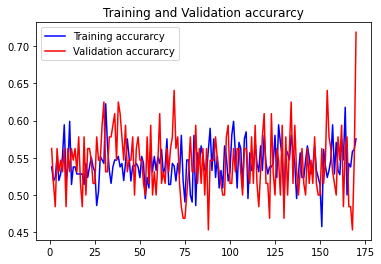

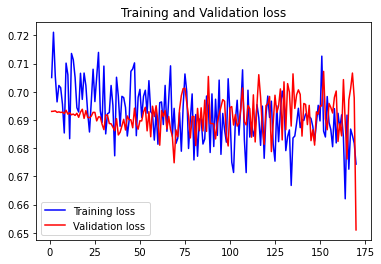

In [61]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

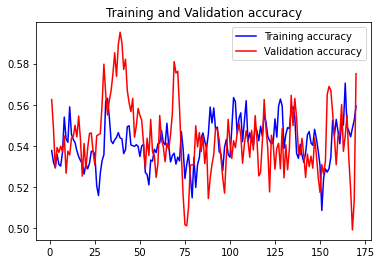

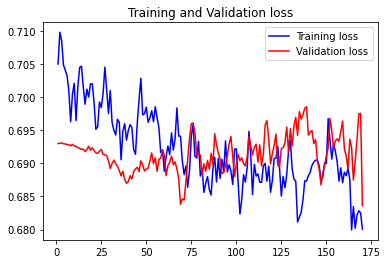

In [62]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accuracy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [65]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 't2':
            X_test.append(array)
            
print(len(X_test), len(y_test))

62 62


In [134]:
x = np.array(X_test)
y = np.array(y_test)
y_pred_class = []
y_pred_prob = []
test_datagen = ImageDataGenerator(rescale=1./255)

correct = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    if i == len(x):
        break
    prob = model.predict(batch)
    y_pred_prob.append(prob)
    prediction = int(np.round(prob))
    y_pred_class.append(prediction)
    actual = y[i]
    if prediction == actual:
        correct += 1
        if prediction == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    i += 1

ACCURACY: 0.6774193548387096
SENSITIVITY: 0.1111111111111111
SPECIFICITY: 0.9090909090909091
0.0,0.0,0.0,0.09090909090909091,0.09090909090909091,0.20454545454545456,0.20454545454545456,0.22727272727272727,0.22727272727272727,0.3409090909090909,0.3409090909090909,0.38636363636363635,0.38636363636363635,0.4318181818181818,0.4318181818181818,0.5227272727272727,0.5227272727272727,0.5909090909090909,0.5909090909090909,0.6590909090909091,0.6590909090909091,0.7954545454545454,0.7954545454545454,0.9090909090909091,0.9090909090909091,0.9545454545454546,0.9545454545454546,1.0,1.0
0.0,0.05555555555555555,0.1111111111111111,0.1111111111111111,0.16666666666666666,0.16666666666666666,0.3333333333333333,0.3333333333333333,0.3888888888888889,0.3888888888888889,0.4444444444444444,0.4444444444444444,0.5,0.5,0.5555555555555556,0.5555555555555556,0.6111111111111112,0.6111111111111112,0.6666666666666666,0.6666666666666666,0.7222222222222222,0.7222222222222222,0.7777777777777778,0.7777777777777778,0.8888888

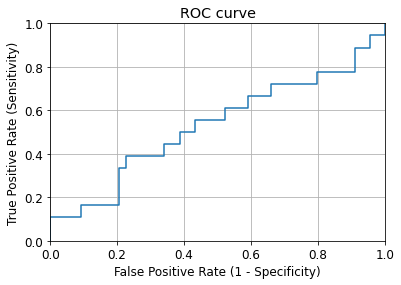

In [135]:
print('ACCURACY:', metrics.accuracy_score(y, y_pred_class))
print('SENSITIVITY:', metrics.recall_score(y, y_pred_class))
print('SPECIFICITY:', true_neg / (true_neg + false_pos))

y_prob = np.array(y_pred_prob).reshape((len(y_pred_prob),))
fpr, tpr, thresholds = metrics.roc_curve(y,y_prob)

print(','.join(str(x) for x in fpr))
print(','.join(str(x) for x in tpr))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC SCORE:', metrics.roc_auc_score(y,y_prob))

In [136]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

evaluate_threshold(0.45)

Sensitivity: 0.5555555555555556
Specificity: 0.5681818181818181


In [139]:
precision, recall, thresholds = metrics.precision_recall_curve(y,y_prob)
print('PRECISION')
print(','.join(str(x) for x in precision))
print()
print('RECALL')
print(','.join(str(x) for x in recall))

PRECISION
0.2903225806451613,0.2786885245901639,0.2833333333333333,0.288135593220339,0.27586206896551724,0.2807017543859649,0.2857142857142857,0.2727272727272727,0.25925925925925924,0.2641509433962264,0.2692307692307692,0.27450980392156865,0.28,0.2857142857142857,0.2708333333333333,0.2765957446808511,0.2826086956521739,0.28888888888888886,0.29545454545454547,0.3023255813953488,0.30952380952380953,0.2926829268292683,0.3,0.3076923076923077,0.3157894736842105,0.2972972972972973,0.3055555555555556,0.3142857142857143,0.3235294117647059,0.30303030303030304,0.3125,0.3225806451612903,0.3333333333333333,0.3448275862068966,0.32142857142857145,0.3333333333333333,0.34615384615384615,0.32,0.3333333333333333,0.34782608695652173,0.3181818181818182,0.3333333333333333,0.35,0.3684210526315789,0.3888888888888889,0.4117647058823529,0.375,0.4,0.35714285714285715,0.3076923076923077,0.25,0.2727272727272727,0.3,0.3333333333333333,0.375,0.42857142857142855,0.3333333333333333,0.4,0.5,0.6666666666666666,1.0,1.0,

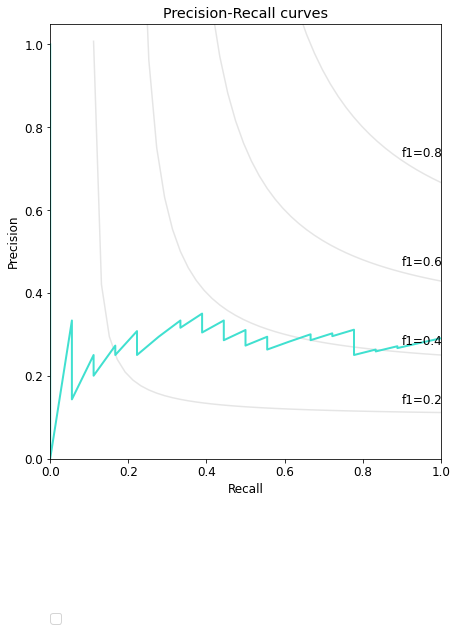

In [131]:
plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision, color='turquoise', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()